# Trabalho prático de dados, parte 2

<u>__Descrição__</u>: Nesta etapa do trabalho prático, o grupo precisava aplicar algum algoritmo de aprendizagem
(regras de associação, regressão, aprendizado supervisionado ou aprendizado não-supervisionado)
para classificar ou agrupar os dados e, assim, tentar prever algum acontecimento desconhecido, com
foco em evasão, nota do ENEM e CRA.

## Imports básicos

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression


## Lendo dataset

In [43]:
df = pd.read_csv("../Datasets/dadosFiltrados.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74026 entries, 0 to 74025
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            74026 non-null  int64  
 1   Ano_Nascimento           73949 non-null  float64
 2   Sexo                     73986 non-null  object 
 3   Campus                   74026 non-null  object 
 4   Curso_Identificador      74026 non-null  int64  
 5   Curso                    74026 non-null  object 
 6   UF_Nascimento            73965 non-null  object 
 7   Municipio_Nascimento     74026 non-null  object 
 8   Admissao                 74026 non-null  object 
 9   Saida                    74026 non-null  object 
 10  Codigo_Situacao_Aluno    74026 non-null  object 
 11  Situacao_Aluno           74026 non-null  object 
 12  Situacao_Aluno_Agrupada  74026 non-null  object 
 13  Modalidade_Inscrita      68753 non-null  float64
 14  ENEM                  

### Selecionando atributos significativos

Vamos primeiramente realizar uma plotagem dos atributos do datasets para ver se conseguimos encontrar alguma correlação pelos gráficos. Para isso, foram selecionadas algumas colunas que possivelmente apresentarão resultados significativos

Como o pairplot plota valores numéricos, foi necessário converter os valores `string` para categóricos, tornando possível a plotagem dos valores

In [122]:
dfCat = df[[  # Selecionando as colunas relevantes para analise
    "Ano_Nascimento" ,
    "Sexo" ,
    "Campus" ,
    "Curso_Identificador" ,
    "UF_Nascimento" ,
    "Codigo_Situacao_Aluno" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Area" ,
    "Admissao_Ano",
    "Saida_Ano",
]]
# Colunas não usada. As colunas abaixo foram desconsideradas ou por serem muito especificas ou por serem redundantes

# ["Identificador" , 
# "Curso" ,
# "UF_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Admissao_Semestre",
# "Saida_Semestre"]

# Vamos converter os atributos desse dataset que são categoricos para variaveis discretas
colunas = dfCat.select_dtypes(include=['object']).columns
for col in colunas:
    dfCat[col] = dfCat[col].astype('category')
for col in colunas:
    dfCat[col] = dfCat[col].cat.codes

# Como dito na analise exploratoria, vamos remover os alunos que não se formaram ainda pois eles atrapalham a visualização
dfCat = dfCat[dfCat['Saida_Ano'] != 0]
dfCat


C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCat[col] = dfCat[col].astype('category')
C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCat[col] = dfCat[col].astype('category')
C:\Users\guizo\AppData\Local\Temp\ipykernel_18508\1367769737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,Ano_Nascimento,Sexo,Campus,Curso_Identificador,UF_Nascimento,Codigo_Situacao_Aluno,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Area,Admissao_Ano,Saida_Ano
0,1982.0,1,1,1101,18,0,0,NaN,0,3,0.0,6,2000,2000
1,1982.0,1,1,1101,6,0,0,NaN,3,3,71.2,6,2000,2002
2,1979.0,0,1,1101,10,2,0,NaN,3,3,78.5,6,2000,2005
3,1979.0,0,1,1101,10,2,0,NaN,20,4,56.0,6,2000,2006
4,1980.0,0,1,1101,25,2,0,NaN,1,3,76.9,6,2000,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73993,2002.0,0,0,2145,7,0,9,602.38,5,1,4.4,4,2022,2022
73994,2002.0,1,2,3101,25,0,9,495.44,5,0,21.2,6,2022,2022
73999,2004.0,1,2,3102,10,0,3,552.52,0,1,74.2,6,2022,2022
74002,NaN,1,2,3109,10,0,9,550.22,5,1,2.6,3,2022,2022


In [123]:
# ## Plotando o pairplot

# plt.figure(figsize=(17, 17))
# sns.pairplot(dfCat, corner=True)
# plt.savefig('Imagens/pairplot.png', format='png', dpi=300)
# plt.close() # impede a impressão da figura na célula. Optamos por salvar a imagem e carregá-la no markdown

![Imagens/pairplot.png](Imagens/pairplot.png)

### Análise do pairplot

O pairplot nos permitiu visualizar alguns padrões muito interessantes, apesar do seu tamanho e complexiddade. Justamente por isso ele foi exportado dentro do arquivo [Imagens/pairplot.png](Imagens/pairplot.png), para permitir sua visualização de forma mais detalhada. 

Para exemplificar, melhor essas relações, vamos fazer também um heatmap dos valores para medir as correlações


<Axes: >

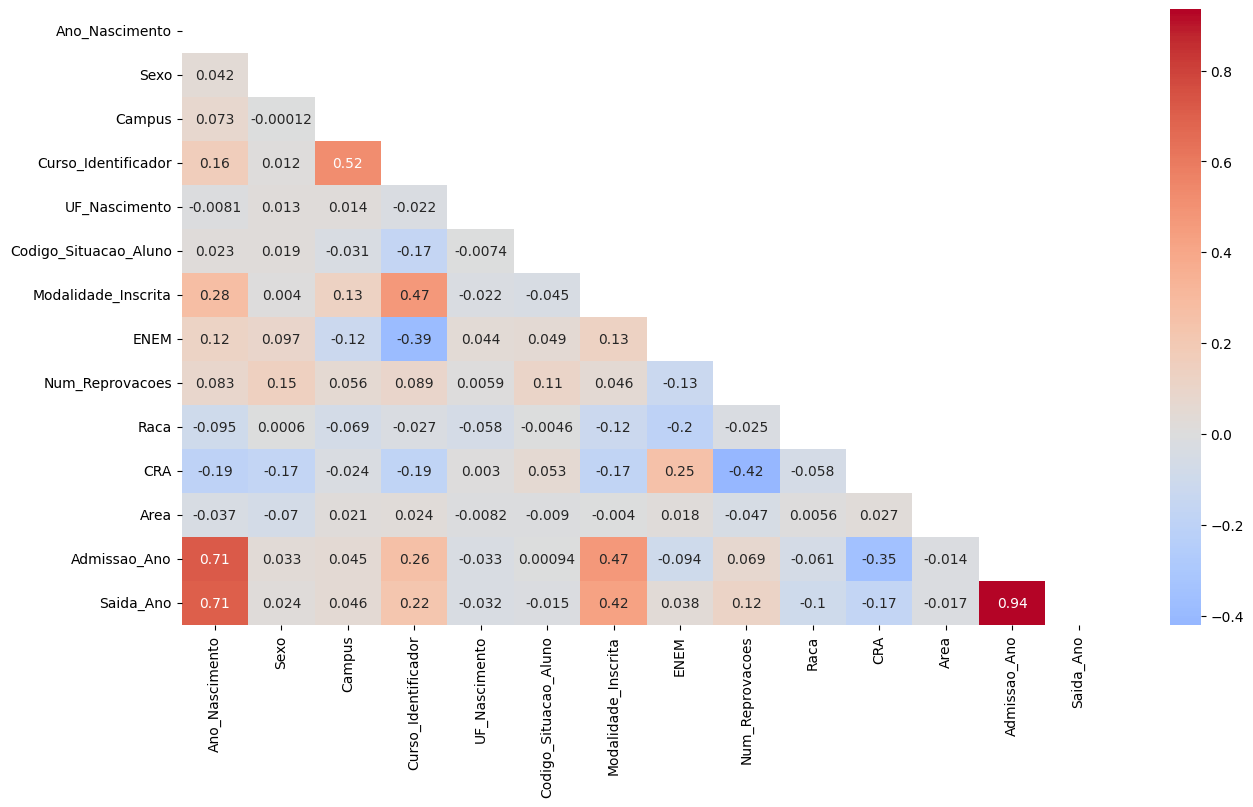

In [125]:
correlation = dfCat.corr()
matrix = np.triu(dfCat.corr())
plt.figure(figsize=(15,8))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, center=0, cmap='coolwarm', mask=matrix)

Note que o Heatmap, em paralelo ao pairplot, são muito esclarecedores em diversos aspectos. É fácil perceber que as variáveis de tempo, tais como ano de saída, ano de admissão, e ano de nascimento estão fortemente interligadas. Isso pode ser facilmente esclarecido por meio do senso comum: Boa parte dos alunos ingressantes na faculdade tendem a entrar alguns anos depois de terminarem o ensino médio. O mesmo vale para a saída da faculdade, que costuma ser o tempo necessário para concluir o curso, levandoo em conta uma certa margem de erro.

Outras relações que podem ser percebidas visualmente é em relação a reprovações e sexo. Apesar do heatmap não medir essa relação muito bem, o pairplot nos mostra que existem muito poucas mulheres com alto número de reprovações (veja no paiplot que a coluna de reprovações femininas é muito menor que a masculina). Com base em tudo isso, iremos realizar algumas análises preditivas.

## Previsão do tempo de duração do curso

Com base nos resultados anteriores, vamos tentar prever a duração de tempo do curso com base em atributos julgados relevantes

In [99]:
dfSaida = df.dropna()
dfSaida = dfSaida[dfSaida['Saida_Ano'] != 0]
dfSaida['Duracao'] = dfSaida['Saida_Ano'] - dfSaida['Admissao_Ano']
dfSaida = dfSaida[[
    "Sexo" ,
    "Campus" ,
    "Codigo_Situacao_Aluno" ,
    "Modalidade_Inscrita" ,
    "ENEM" ,
    "Num_Reprovacoes" ,
    "Raca" ,
    "CRA" ,
    "Area" ,
    "Duracao"]]

# Atributos desconsiderados
# ["Identificador" ,
# "Ano_Nascimento" ,
# "Curso" ,
# "UF_Nascimento" ,
# "Admissao" ,
# "Saida" ,
# "Situacao_Aluno" ,
# "Situacao_Aluno_Agrupada" ,
# "Curso_Identificador" ,
# "Admissao_Semestre",
# "Saida_Semestre"]

dfSaida.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25824 entries, 24119 to 73999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sexo                   25824 non-null  object 
 1   Campus                 25824 non-null  object 
 2   Codigo_Situacao_Aluno  25824 non-null  object 
 3   Modalidade_Inscrita    25824 non-null  object 
 4   ENEM                   25824 non-null  float64
 5   Num_Reprovacoes        25824 non-null  int64  
 6   Raca                   25824 non-null  object 
 7   CRA                    25824 non-null  float64
 8   Area                   25824 non-null  object 
 9   Duracao                25824 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.2+ MB


In [100]:
dfSaida = pd.get_dummies(dfSaida, columns=[
    'Sexo', 
    'Campus',
    'Codigo_Situacao_Aluno', 
    'Modalidade_Inscrita', 
    'Raca',
    'Area',
    ], drop_first=True)
x = dfSaida.drop(columns=['Duracao'])
y = dfSaida['Duracao']
x.columns

Index(['ENEM', 'Num_Reprovacoes', 'CRA', 'Sexo_M', 'Campus_CAV', 'Campus_CRP',
       'Codigo_Situacao_Aluno_B', 'Codigo_Situacao_Aluno_C',
       'Codigo_Situacao_Aluno_D', 'Codigo_Situacao_Aluno_F',
       'Codigo_Situacao_Aluno_G', 'Codigo_Situacao_Aluno_I',
       'Codigo_Situacao_Aluno_M', 'Codigo_Situacao_Aluno_N',
       'Codigo_Situacao_Aluno_Q', 'Codigo_Situacao_Aluno_S',
       'Codigo_Situacao_Aluno_T', 'Codigo_Situacao_Aluno_X',
       'Modalidade_Inscrita_1.0', 'Modalidade_Inscrita_2.0',
       'Modalidade_Inscrita_3.0', 'Modalidade_Inscrita_4.0',
       'Modalidade_Inscrita_5.0', 'Modalidade_Inscrita_6.0',
       'Modalidade_Inscrita_7.0', 'Modalidade_Inscrita_8.0',
       'Modalidade_Inscrita_9.0', 'Modalidade_Inscrita_nan', 'Raca_Branco(a)',
       'Raca_Indígena', 'Raca_Informação não disponível', 'Raca_Pardo(a)',
       'Raca_Preto(a)', 'Area_CIENCIAS AGRARIAS', 'Area_CIENCIAS DA SAUDE',
       'Area_CIENCIAS ECONOMICAS', 'Area_CIENCIAS EXATAS E DA TERRA',
       'Are

In [101]:

lm = LinearRegression()
lm.fit(x, y)

print('Coeficiente estimado: ', lm.coef_)
print('R2 (score): ', lm.score(x,y))

Coeficiente estimado:  [ 1.12552162e-03  1.41842256e-01  2.24563680e-02  1.55215257e-02
  1.18444034e-02 -9.16838049e-02  3.32184222e+00  2.54142728e+00
 -1.98943582e-01  2.53664663e-01  1.68526547e+00  3.27979618e+00
 -4.19179748e-01  1.67546902e+00  4.75278735e+00 -4.20888934e-01
 -3.36871986e-01 -8.97333998e-01 -3.92531951e-02  4.51884415e-01
  3.91691954e-02  1.45520997e-01 -8.01481102e-02 -1.07930638e-02
 -5.51474757e-02  2.67350774e-01 -1.04609692e-01 -1.43974693e-01
 -4.60998696e-02  2.51109364e-02 -4.32298714e-01 -6.34995929e-02
 -1.84469432e-02  3.79355353e-02  3.17546514e-01  2.75728442e-01
  1.86592196e-01  2.03275831e-01  4.55387326e-01  2.72116077e-02
  2.01085907e-01  8.39860747e-02  4.23750850e-01]
R2 (score):  0.725356666414188


analises possiveis:
- mulheres reprovam menos
- reprovação por campus
- enem vs reprovçoes
- cra reprovaçoes